In [105]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import pickle
import scipy.optimize as optim
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots
from datetime import datetime, timedelta
c = '#386B7F' # basic color for plots

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

logging.getLogger().setLevel(logging.ERROR)
    
%matplotlib inline

%store -r WORKDIR

if 'WORKDIR' not in dir():
    WORKDIR = 'C:/Users/thewr/git/mit_data_science.git/'

dataset_max_date  = pd.Timestamp('26-Mar-2006')
dataset_min_date = pd.Timestamp(dataset_max_date - timedelta(days = 30))

time_col = 'ds'
target_col = 'y'

data_proc_file = WORKDIR + '/Data/Processed/energy_consumption_data_modeling.parquet'
model_score_file = WORKDIR + '/Data/Modeling/model_scores.parquet'
model_file = WORKDIR + '/Data/Modeling/trained_models.jbl'


# Carga dos Dados 

In [106]:
pjme = pd.read_parquet(data_proc_file)
pjme.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 8710 entries, 0 to 8709
Data columns (total 2 columns):
Datetime    8710 non-null datetime64[ns]
PJME_MW     8710 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 204.1 KB


In [107]:
if os.path.exists(model_score_file):
    df_score_model = pd.read_parquet(model_score_file)
    print(df_score_model['date_end'][0])
    if not df_score_model.empty:
        date_end = pd.Timestamp(df_score_model['date_end'][0].strftime('%Y.%m.%d'))    
    if pd.notnull(date_end):
        dataset_max_date  = pd.Timestamp(date_end + timedelta(days = 5))
else: dataset_max_date  = dataset_max_date  


In [108]:
print(dataset_max_date)

2006-03-26 00:00:00


In [109]:
dataset_min_date = pd.Timestamp(dataset_max_date - timedelta(days = 30))

In [110]:
print(dataset_min_date)                 

2006-02-24 00:00:00


In [111]:
pjme.head()

,Datetime,PJME_MW
0,2006-01-01 00:00:00,30293.0
1,2006-01-01 01:00:00,28884.0
2,2006-01-01 02:00:00,27556.0
3,2006-01-01 03:00:00,26484.0
4,2006-01-01 04:00:00,25822.0


In [112]:
pjme.columns

Index(['Datetime', 'PJME_MW'], dtype='object')

In [113]:
pjme.set_index('Datetime',inplace=True)

In [114]:
pjme = pjme[dataset_min_date:dataset_max_date]

print('shape:', pjme.shape)
print('columns:', pjme.columns)

shape: (721, 1)
columns: Index(['PJME_MW'], dtype='object')


In [115]:
pjme.head()

,PJME_MW
Datetime,
2006-02-24 00:00:00,30862.0
2006-02-24 01:00:00,28921.0
2006-02-24 02:00:00,27917.0
2006-02-24 03:00:00,27621.0
2006-02-24 04:00:00,27727.0


In [116]:
pjme.tail()

,PJME_MW
Datetime,
2006-03-25 20:00:00,32353.0
2006-03-25 21:00:00,31744.0
2006-03-25 22:00:00,30690.0
2006-03-25 23:00:00,29235.0
2006-03-26 00:00:00,27408.0


In [117]:
pjme.shape

(721, 1)

In [118]:
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 721 entries, 2006-02-24 00:00:00 to 2006-03-26 00:00:00
Data columns (total 1 columns):
PJME_MW    721 non-null float64
dtypes: float64(1)
memory usage: 11.3 KB


In [119]:
pjme = pjme.reset_index()

In [120]:
split_date = pd.Timestamp(pjme.iloc[int(pjme.shape[0] * 0.80)]['Datetime'])

In [121]:
print(split_date)

2006-03-20 00:00:00


In [122]:
pjme.head()

,Datetime,PJME_MW
0,2006-02-24 00:00:00,30862.0
1,2006-02-24 01:00:00,28921.0
2,2006-02-24 02:00:00,27917.0
3,2006-02-24 03:00:00,27621.0
4,2006-02-24 04:00:00,27727.0


In [123]:
pjme.set_index('Datetime', inplace=True)

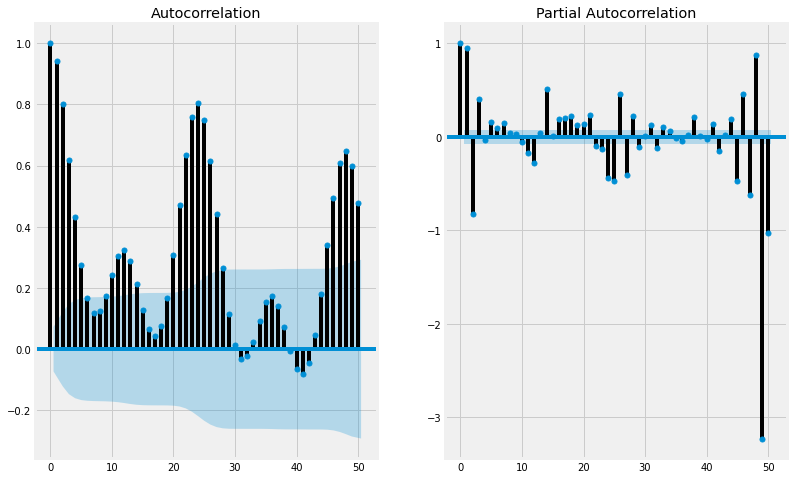

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
plot_acf(x=pjme['PJME_MW'], lags = 50, ax=ax[0])
plot_pacf(x=pjme['PJME_MW'], lags = 50, ax=ax[1]);


# Treino / Teste 

In [125]:
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [126]:
pd.plotting.register_matplotlib_converters()

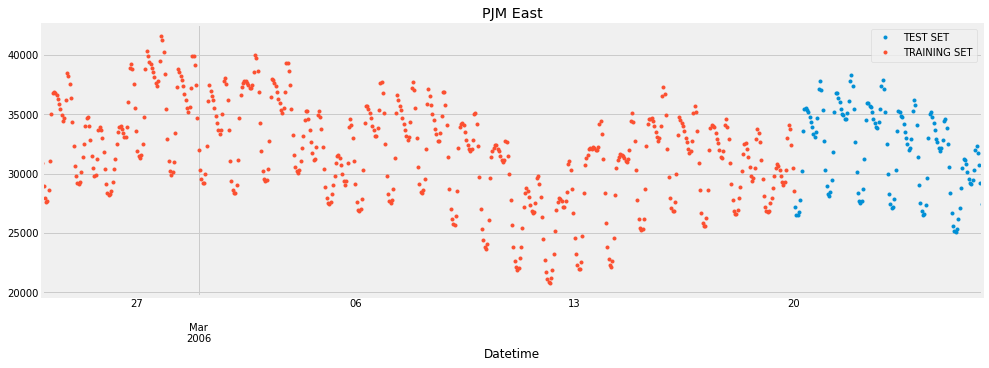

In [127]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [128]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':time_col,
                     'PJME_MW':target_col}).head()

,ds,y
0,2006-02-24 00:00:00,30862.0
1,2006-02-24 01:00:00,28921.0
2,2006-02-24 02:00:00,27917.0
3,2006-02-24 03:00:00,27621.0
4,2006-02-24 04:00:00,27727.0


In [129]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':time_col,
                               'PJME_MW':target_col}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [130]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':time_col}))

In [131]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-03-20 01:00:00,32534.403534,26531.407924,29399.658998,32534.403534,32534.403534,-4545.944373,-4545.944373,-4545.944373,-3812.320640,-3812.320640,-3812.320640,-733.623733,-733.623733,-733.623733,0.0,0.0,0.0,27988.459161
1,2006-03-20 02:00:00,32558.595313,25692.026277,28730.895603,32558.595313,32558.595313,-5349.541493,-5349.541493,-5349.541493,-4776.806591,-4776.806591,-4776.806591,-572.734903,-572.734903,-572.734903,0.0,0.0,0.0,27209.053820
2,2006-03-20 03:00:00,32582.787092,25427.804690,28382.750097,32582.787092,32582.787092,-5742.034493,-5742.034493,-5742.034493,-5325.964199,-5325.964199,-5325.964199,-416.070293,-416.070293,-416.070293,0.0,0.0,0.0,26840.752599
3,2006-03-20 04:00:00,32606.978871,25618.885605,28623.062250,32606.978871,32606.978871,-5538.194470,-5538.194470,-5538.194470,-5273.618028,-5273.618028,-5273.618028,-264.576442,-264.576442,-264.576442,0.0,0.0,0.0,27068.784401
4,2006-03-20 05:00:00,32631.170650,26752.353091,29643.245999,32631.170650,32631.172484,-4449.044275,-4449.044275,-4449.044275,-4329.917411,-4329.917411,-4329.917411,-119.126864,-119.126864,-119.126864,0.0,0.0,0.0,28182.126375


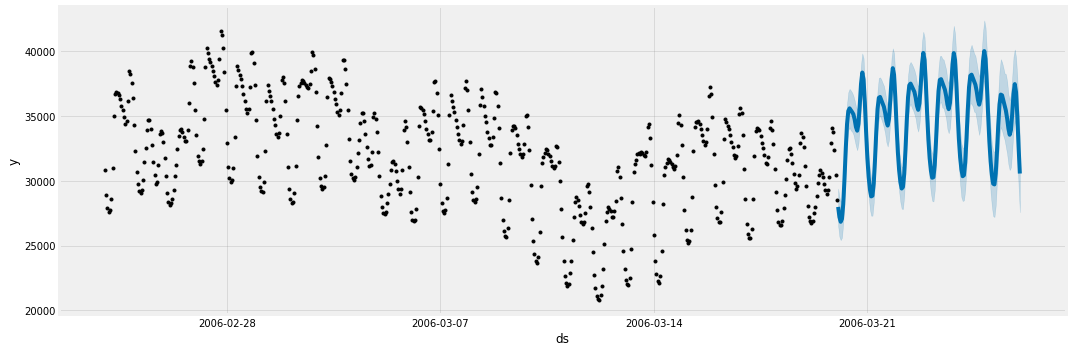

In [132]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

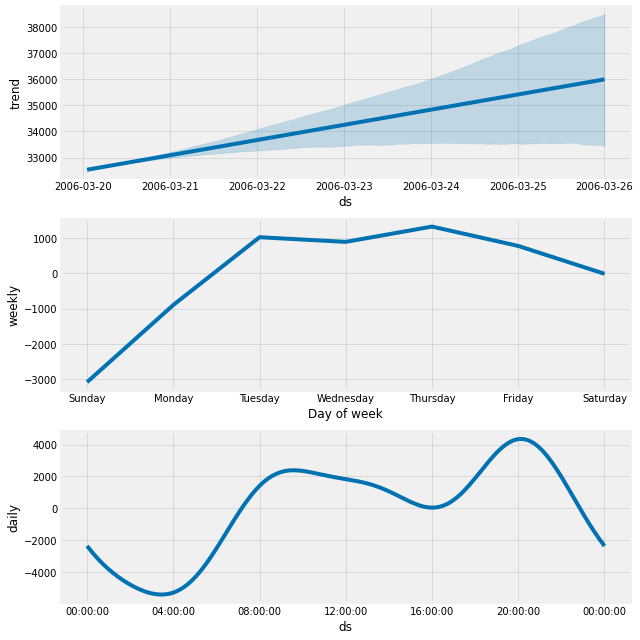

In [133]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

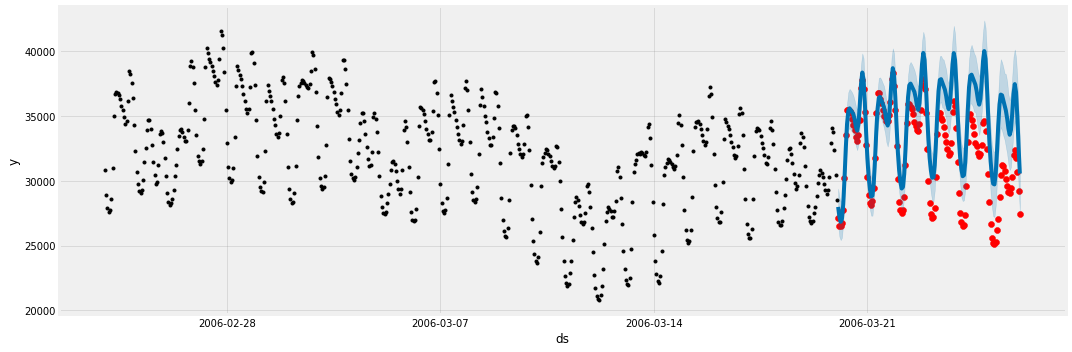

In [134]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [135]:
month_lower_date = pd.Timestamp(split_date)
month_upper_date = pd.Timestamp(split_date + timedelta(days = 5))

week_lower_date = pd.Timestamp(split_date)
week_upper_date = pd.Timestamp(split_date + timedelta(days = 1))

# Error Metrics
Our RMSE error is 15987910.88
Our MAE error is 3247.98
Our MAPE error is 10.344

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE): Check that out here

In [136]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

10029217.921819372

In [137]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

2603.232239230226

In [138]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

In [139]:
print(score)

8.449281526369482


In [140]:
pjme.head()

,PJME_MW
Datetime,
2006-02-24 00:00:00,30862.0
2006-02-24 01:00:00,28921.0
2006-02-24 02:00:00,27917.0
2006-02-24 03:00:00,27621.0
2006-02-24 04:00:00,27727.0


In [141]:
pjme = pjme.reset_index()

In [142]:
pjme.head()

,Datetime,PJME_MW
0,2006-02-24 00:00:00,30862.0
1,2006-02-24 01:00:00,28921.0
2,2006-02-24 02:00:00,27917.0
3,2006-02-24 03:00:00,27621.0
4,2006-02-24 04:00:00,27727.0


In [143]:
Xrefit = pjme.copy()

In [144]:
Xrefit.columns = [time_col,target_col]

In [145]:
Xrefit.head()

,ds,y
0,2006-02-24 00:00:00,30862.0
1,2006-02-24 01:00:00,28921.0
2,2006-02-24 02:00:00,27917.0
3,2006-02-24 03:00:00,27621.0
4,2006-02-24 04:00:00,27727.0


In [146]:
Xrefit.tail()

,ds,y
716,2006-03-25 20:00:00,32353.0
717,2006-03-25 21:00:00,31744.0
718,2006-03-25 22:00:00,30690.0
719,2006-03-25 23:00:00,29235.0
720,2006-03-26 00:00:00,27408.0


# Construção do Pipeline 

In [147]:
trained_models = {}
df_model_result=pd.DataFrame()

result_list = []

model = Prophet()
trained_models = model.fit(Xrefit.reset_index())
    
    #result list
result_list.append({'model_name': 'prophet',
                        'date_begin': Xrefit.ds.min(),
                        'date_end'  : Xrefit.ds.max(),
                        'score': score})
    
df_results = pd.DataFrame().from_dict(result_list)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [148]:
df_results.head()

,model_name,date_begin,date_end,score
0,prophet,2006-02-24,2006-03-26,8.449282


# Exportar os resultados e modelagem 

In [149]:
# exportar a tabela de resultados

#data_proc_file = WORKDIR + '/Data/Processed/energy_consumption_data_modeling.parquet'
#model_score_file = WORKDIR + '/Data/Modeling/model_scores.parquet'
#model_file = WORKDIR + '/Data/Modeling/trained_models.jbl'
df_results.to_parquet(model_score_file)

filename = model_score_file.replace(".parquet","_" + df_results.date_end.max().date().strftime('%Y-%m-%d') + ".parquet") 
df_results.to_parquet(filename)

filename = model_file  
pickle.dump(trained_models, open(filename, 'wb'))


filename = model_file.replace(".jbl","_" + df_results.date_end.max().date().strftime('%Y-%m-%d') + ".jbl")     
#with open(trained_models, 'wb') as fid:
    #pickle.dump(trained_models, fid)
pickle.dump(trained_models, open(filename, 'wb'))
    
    
    
df_results.head()

,model_name,date_begin,date_end,score
0,prophet,2006-02-24,2006-03-26,8.449282


In [150]:
df_results.head()

,model_name,date_begin,date_end,score
0,prophet,2006-02-24,2006-03-26,8.449282


In [151]:
df_results.head()

,model_name,date_begin,date_end,score
0,prophet,2006-02-24,2006-03-26,8.449282
